In [4]:
import re
import datetime
import pandas as pd
import json
from osisoft.pidevclub.piwebapi.pi_web_api_client import PIWebApiClient
from pandasgui import show
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import pickle

In [5]:
df_nea_hora_con_ratios = pd.read_csv('DataSet/colapso.csv')

In [3]:
#df_nea_hora_con_ratios = pd.read_csv('df_nea_hora_con_ratios_test.csv')

In [6]:
df_nea_hora_con_ratios.set_index('Timestamp', inplace=True)

In [7]:
y = df_nea_hora_con_ratios['Colapso'].dropna()  # Drop rows with NaN values in the target variable

# Drop corresponding rows in the feature matrix
X = df_nea_hora_con_ratios.drop(['Colapso'], axis=1).loc[y.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=df_nea_hora_con_ratios['Colapso'])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.1, shuffle=True, stratify=y_train)

print("Train:", len(X_train))
print("Tests:", len(X_test))
print("Validation:", len(X_val))

Train: 3526
Tests: 980
Validation: 392


In [8]:
X_train_rn = X_train.copy()
X_test_rn = X_test.copy()
X_val_rn = X_val.copy()
y_train_rn = y_train.copy()
y_test_rn = y_test.copy()
y_val_rn = y_val.copy()

In [9]:
X_test.to_pickle('df_test.pkl')

In [10]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(0, inplace=True)

X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.fillna(0, inplace=True)

X_val.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val.fillna(0, inplace=True)

In [11]:
def modelo_simplificado(X):
    datetime_index = pd.DatetimeIndex(X.index)
    conditions = (
        (X['RESISTEN/TEMP.AV'] >= 35) & (X['RESISTEN/TEMP.AV'] <= 40) &
        (datetime_index.hour >= 13) & (datetime_index.hour <= 18)
    )

    predictions = conditions.apply(lambda condition: 1 if condition else 2)
    
    return predictions


In [12]:
predictions_train = modelo_simplificado(X_train)
predictions_val = modelo_simplificado(X_val)
predictions_test = modelo_simplificado(X_test)

In [13]:
accuracy_val = accuracy_score(predictions_val, y_val)
precision_val = precision_score(predictions_val, y_val, average='weighted')
recall_val = recall_score(y_val, y_val, average='weighted')
f1_val = f1_score(predictions_val, y_val, average='weighted')

print(accuracy_val, precision_val, recall_val, f1_val)

0.4770408163265306 0.5886935131195334 1.0 0.40829183919605805


In [12]:
# def evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Scale=False, Model='logistic'):
#     if Scale:
#         scaler = StandardScaler()
#         X_train = scaler.fit_transform(X_train)
#         X_val = scaler.transform(X_val)
#         X_test = scaler.transform(X_test)

#     if Model == 'logistic':
#         model = LogisticRegression(max_iter=1000)
#     elif Model == 'random_forest':
#         model = RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
#     elif Model == 'gradient_boosting':
#         model = GradientBoostingClassifier()
#     elif Model == 'svm':
#         model = SVC(kernel='linear', probability=True)
#     elif Model == 'knn':  
#         model = KNeighborsClassifier(n_neighbors=9, metric="minkowski", p=2)
#     elif Model == 'decision_tree_classifier':  
#         model = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
#     else:
#         raise ValueError("Model type not recognized")

#     model.fit(X_train, y_train)
#     y_pred_val = model.predict(X_val)
#     y_pred_test = model.predict(X_test)

#     #sns.histplot(data=y_pred_val)

#     accuracy_val = accuracy_score(y_pred_val, y_val)
#     precision_val = precision_score(y_pred_val, y_val, average='weighted')
#     recall_val = recall_score(y_pred_val, y_val, average='weighted')
#     f1_val = f1_score(y_pred_val, y_val, average='weighted')

#     metrics_val_df = pd.DataFrame({
#         'Modelo': [Model],
#         'Scale': [Scale],
#         'Accuracy': [accuracy_val],
#         'Precision': [precision_val],
#         'Recall': [recall_val],
#         'F1': [f1_val]
#     })

#     # Calculamos la probabilidad del modelo
#     prob_total = model.predict_proba(X_test)[:, -1] # para llevarlo a 1-d

#     if hasattr(model, 'decision_function'):
#         scores = model.decision_function(X_test)
#     else:
#         scores = model.predict_proba(X_test)[:, 1] 
    
#     # Realizar la curva ROC
#     fpr_total, tpr_total, _ = roc_curve(y_true=y_test, y_score=scores, pos_label=1)  
#     roc_auc = auc(fpr_total, tpr_total)

#     # Ploteamos la curva ROC
#     plt.plot(fpr_total, tpr_total, label=f"Modelo (AUC = {roc_auc:.2f})")
#     plt.xlim([-0.01, 1.01])
#     plt.ylim([-0.01, 1.01])
#     plt.xlabel("Tasa de falsos positivos")
#     plt.ylabel("Tasa de verdaderos positivos")
#     plt.legend()

#     print(f"Informe de clasificación para el modelo {Model} en conjunto de prueba:")
#     print(classification_report(y_test, y_pred_test))

#     accuracy_test = accuracy_score(y_pred_test, y_test)

#     return metrics_val_df

In [13]:
# df_result = pd.DataFrame()

# df_result = pd.concat([df_result, evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Scale=True, Model='logistic')], ignore_index=True)
# df_result = pd.concat([df_result, evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Scale=True, Model='random_forest')], ignore_index=True)
# df_result = pd.concat([df_result, evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Scale=True, Model='gradient_boosting')], ignore_index=True)
# df_result = pd.concat([df_result, evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Scale=True, Model='svm')], ignore_index=True)
# df_result = pd.concat([df_result, evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Scale=True, Model='knn')], ignore_index=True)
# df_result = pd.concat([df_result, evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Scale=True, Model='decision_tree_classifier')], ignore_index=True)

# print(df_result)

c:\Users\CBureu\.virtualenvs\NEA-jRDK6KIF\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Métricas para Regresión Logística:
Accuracy: 0.8826530612244898
Precision: 0.8733766233766234
Recall: 0.8826530612244898
F1 Score: 0.876641604010025


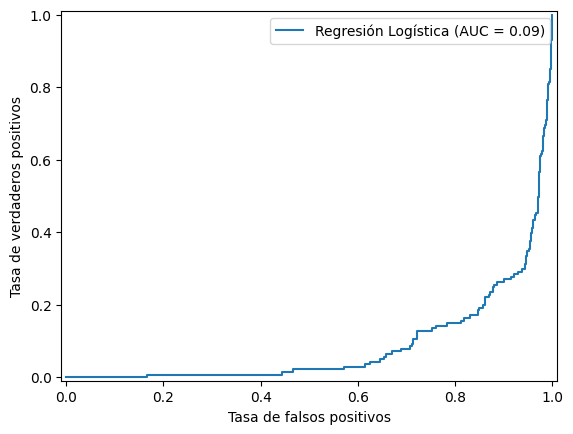

In [14]:
from sklearn.linear_model import LogisticRegression

# Crear y entrenar el modelo de Regresión Logística
logistic_model = LogisticRegression(max_iter=1000, C=0.1, random_state=42)
logistic_model.fit(X_train, y_train)

# Guardar el modelo de Regresión Logística
pickle.dump(logistic_model, open('logistic_model.pkl', 'wb'))

# Predecir en los conjuntos de validación y prueba con Regresión Logística
y_pred_logistic_val = logistic_model.predict(X_val)
y_pred_logistic_test = logistic_model.predict(X_test)

# Calcular métricas de evaluación para Regresión Logística
accuracy_logistic_val = accuracy_score(y_val, y_pred_logistic_val)
precision_logistic_val = precision_score(y_val, y_pred_logistic_val, average='weighted')
recall_logistic_val = recall_score(y_val, y_pred_logistic_val, average='weighted')
f1_logistic_val = f1_score(y_val, y_pred_logistic_val, average='weighted')

# Calcular la probabilidad del modelo de Regresión Logística
if hasattr(logistic_model, 'decision_function'):
    scores_logistic = logistic_model.decision_function(X_test)
else:
    scores_logistic = logistic_model.predict_proba(X_test)[:, 1] 

# Realizar la curva ROC para Regresión Logística
fpr_logistic, tpr_logistic, _ = roc_curve(y_true=y_test, y_score=scores_logistic, pos_label=1)  
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# Ploteamos la curva ROC para Regresión Logística
plt.plot(fpr_logistic, tpr_logistic, label=f"Regresión Logística (AUC = {roc_auc_logistic:.2f})")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.legend()

# Mostrar métricas para Regresión Logística
print("Métricas para Regresión Logística:")
print(f"Accuracy: {accuracy_logistic_val}")
print(f"Precision: {precision_logistic_val}")
print(f"Recall: {recall_logistic_val}")
print(f"F1 Score: {f1_logistic_val}")

# Mostrar la curva ROC para Regresión Logística
plt.show()


In [15]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'criterion': ['gini', 'entropy']
# }

# model = RandomForestClassifier()

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='recall', cv=5, n_jobs=-1)

# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_
# print("Mejores hiperparámetros:", best_params)


Accuracy: 0.9617346938775511
Precision: 0.9622937867090595
Recall: 0.9617346938775511
F1 Score: 0.9595854267387114


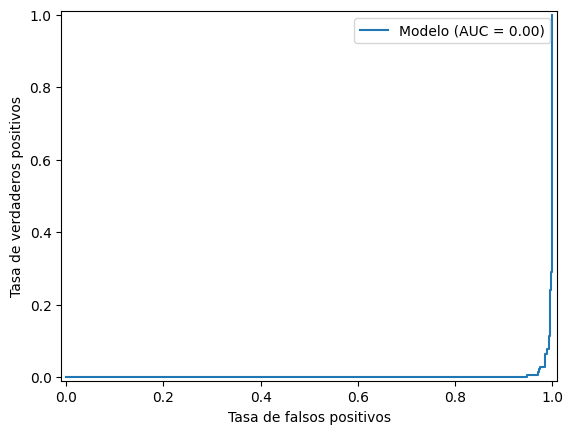

In [15]:
# Crear e entrenar el modelo RandomForestClassifier
model = RandomForestClassifier(criterion='gini', max_depth= 10, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 50)
model.fit(X_train, y_train)

pickle.dump(model, open('model.pkl', 'wb')) #save
 
# Predecir en los conjuntos de validación y prueba
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

# Calcular métricas de evaluación
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val, average='weighted')
recall_val = recall_score(y_val, y_pred_val, average='weighted')
f1_val = f1_score(y_val, y_pred_val, average='weighted')

# Calcular la probabilidad del modelo
if hasattr(model, 'decision_function'):
    scores = model.decision_function(X_test)
else:
    scores = model.predict_proba(X_test)[:, 1] 

# Realizar la curva ROC
fpr_total, tpr_total, _ = roc_curve(y_true=y_test, y_score=scores, pos_label=1)  
roc_auc = auc(fpr_total, tpr_total)

# Ploteamos la curva ROC
plt.plot(fpr_total, tpr_total, label=f"Modelo (AUC = {roc_auc:.2f})")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.legend()

# Mostrar métricas
print(f"Accuracy: {accuracy_val}")
print(f"Precision: {precision_val}")
print(f"Recall: {recall_val}")
print(f"F1 Score: {f1_val}")

# Mostrar la curva ROC
plt.show()


In [31]:
from sklearn.tree import export_graphviz
import graphviz

In [39]:
estimator = model.estimators_[1]  # Tomamos un solo árbol del modelo RandomForestClassifier
export_graphviz(estimator, out_file='tree.dot', 
                feature_names=X_train.columns,
                class_names=['No Colapso', 'Colapso'],
                filled=True, rounded=True, 
                special_characters=True)

In [40]:
with open("tree.dot") as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

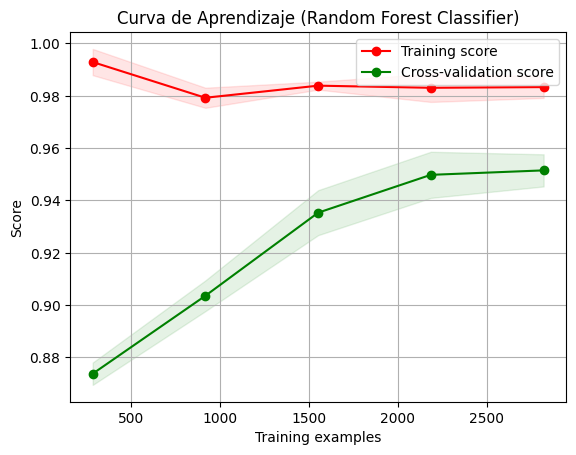

In [16]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, title, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Título del gráfico
title = "Curva de Aprendizaje (Random Forest Classifier)"

# Crear y mostrar la curva de aprendizaje
plot_learning_curve(model, title, X_train, y_train, cv=5, n_jobs=-1)

plt.show()


In [17]:
# Obtener la importancia de las características desde el modelo
importances = model.feature_importances_

# Obtener nombres de las características
nombres_caracteristicas = X_train.columns

# Crear un DataFrame para visualizar mejor la importancia de las características
importancias_df = pd.DataFrame({'Característica': nombres_caracteristicas, 'Importancia': importances})
importancias_df = importancias_df.sort_values(by='Importancia', ascending=False)

# Puedes imprimir el DataFrame si deseas ver la importancia de cada característica en detalle
importancias_df.head(15)


,Característica,Importancia
22,BASAVIL/132/NOGOYA/Q.AV,0.014346
189,S.CATALI/13/ALIME15/I.AV,0.013761
83,FORMOSA/13/DIST104/I.AV,0.013585
165,RESISTEN/132/CD5/I.AV,0.011971
0,DEM_NEA/TOT_DEM_____P.AV,0.011923
203,S.ISIDRO/500/TRAFO2/P.AV,0.011656
47,CLORINDA/132/LBLANCA/Q.AV,0.011513
88,FORMOSA2/33/TRAFO1/P.AV,0.011391
204,S.ISIDRO/500/TRAFO2/Q.AV,0.010959
7,ALLEN/132/G.ROCA/P.AV,0.010718


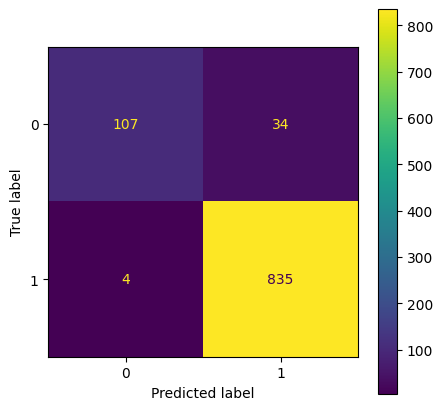

In [18]:
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5,5))
ax.grid(False)
disp.plot(ax=ax);

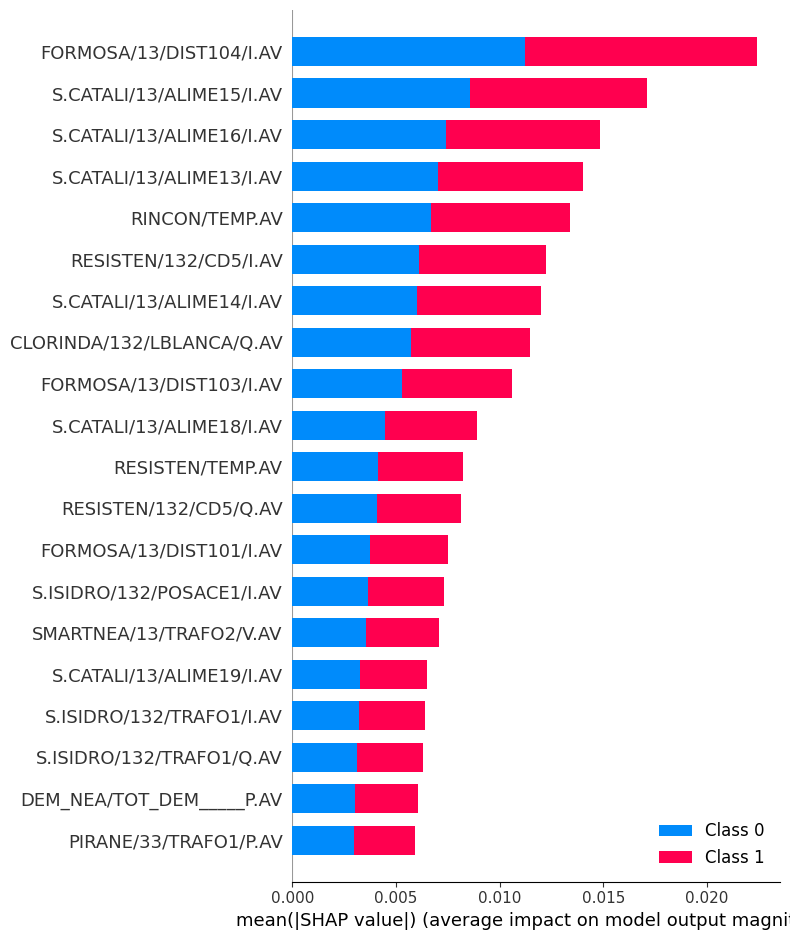

In [19]:
import shap

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, X_val, feature_names=df_nea_hora_con_ratios.columns)


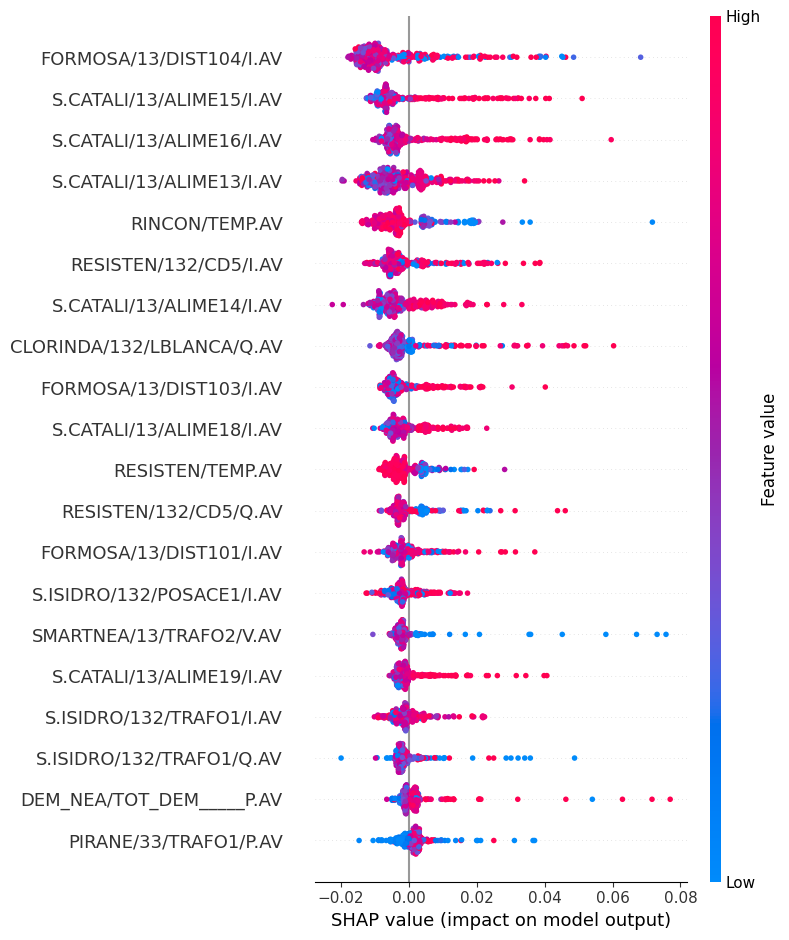

In [20]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values[0], X_val, feature_names=df_nea_hora_con_ratios.columns)

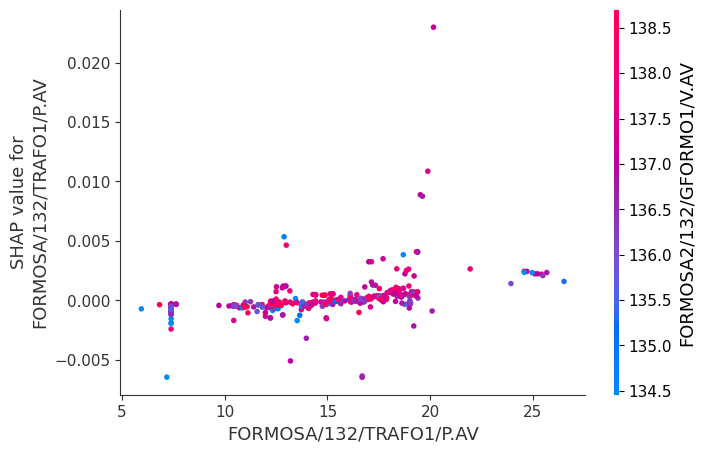

In [21]:
shap_values_for_class = shap_values[0]
#feature_of_interest = 'RESISTEN/TEMP.AV'
#feature_of_interest = 'FORMOSA2/132/GFORMO1/I.AV'
#feature_of_interest = 'FORMOSA/13/DIST104/I.AV'
#feature_of_interest = 'I.JUAREZ/132/TRAFO1/QP_RATIO'
#feature_of_interest = 'MANSILLA/132/LEONESA/QP_RATIO'
#feature_of_interest = 'LOMITAS/132/TRAFO1/QP_RATIO'
#feature_of_interest = 'SMARTNEA/13/TRAFO2/Q.AV'
feature_of_interest = 'FORMOSA/132/TRAFO1/P.AV'
#feature_of_interest = 'FORMOSA/132/FORMOS3/I.AV'
#feature_of_interest = 'S.ISIDRO/132/TRAFO1/Q.AV'
#feature_of_interest = 'PIRANE/33/TRAFO1/P.AV'
#interaction_feature = 'DEM_NEA/TOT_DEM_____P.AV'
#interaction_feature = 'RESISTEN/TEMP.AV'
interaction_feature = 'FORMOSA2/132/GFORMO1/V.AV'

shap.dependence_plot(feature_of_interest, shap_values_for_class, X_val, feature_names=df_nea_hora_con_ratios.columns, interaction_index=interaction_feature)

plt.show()

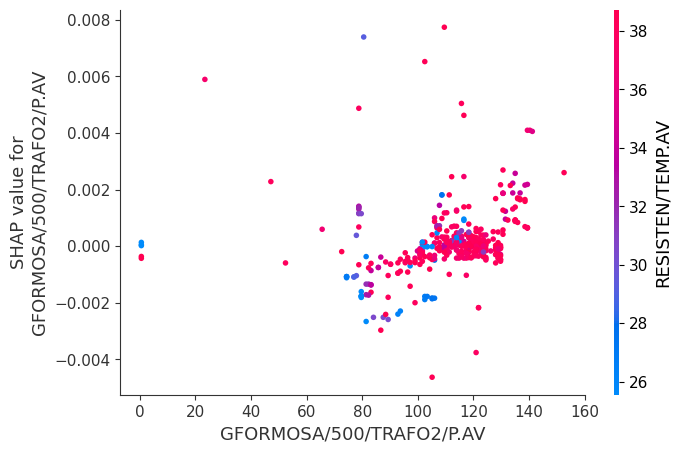

In [22]:
shap_values_for_class = shap_values[0]
feature_of_interest = 'GFORMOSA/500/TRAFO2/P.AV'
interaction_feature = 'RESISTEN/TEMP.AV'

shap.dependence_plot(feature_of_interest, shap_values_for_class, X_val, feature_names=df_nea_hora_con_ratios.columns, interaction_index=interaction_feature)

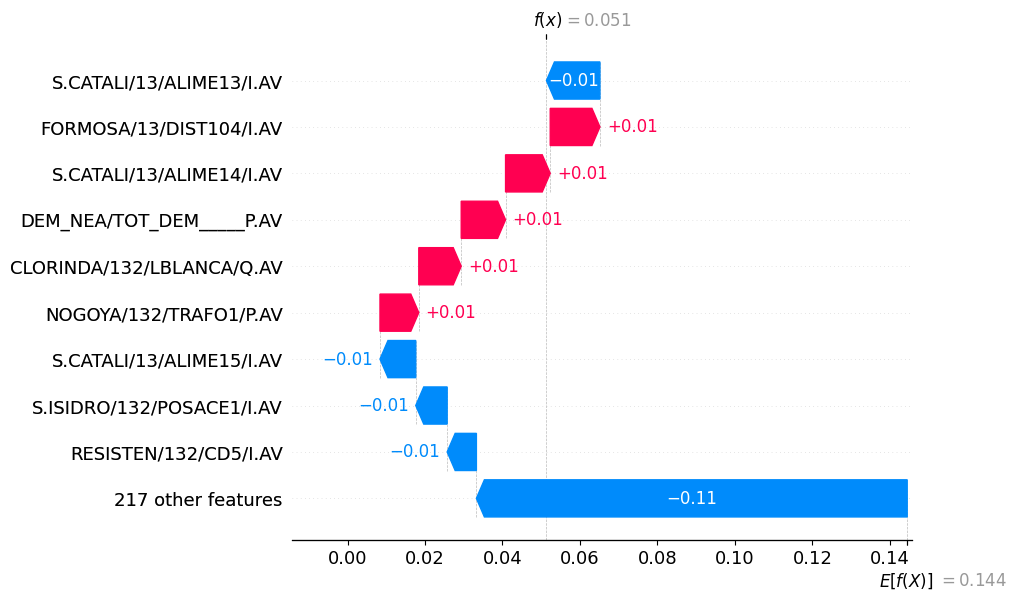

In [23]:
shap_values_for_class = shap_values[0]

feature_names = X_val.columns

# Crear un objeto Explanation directamente
shap_exp = shap.Explanation(shap_values_for_class, base_values=explainer.expected_value, feature_names=feature_names)

# Visualizar el gráfico de cascada (waterfall plot)
shap.plots.waterfall(shap_exp[0])
plt.show()

